**Prepare dataset**

In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from utils import LogitsToPredicate, MLP, MultiKANModel, DataLoader, DataLoaderMulti
from kan import KAN

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

X_columns = [
    'Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Srate', 
    # 'Drate',
    # 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number',
    # 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count',
    # 'syn_count', 'fin_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet',
    # 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IGMP', 
    'IPv','LLC', 
    'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number',
    'Magnitue', 'Radius', 'Covariance',
    # 'Variance', 'Weight'
]

Y_columns = ['label_L2']

label_L1_mapping = {"MQTT": 0, "Benign": 1} 
label_L2_mapping = {"MQTT-DDoS-Connect_Flood": 0, "MQTT-DDoS-Publish_Flood": 1, 
                    "MQTT-DoS-Connect_Flood": 2, "MQTT-DoS-Publish_Flood": 3,
                    "MQTT-Malformed_Data": 4, "Benign": 5} 


# Read the CSV file
df = pd.read_csv('/home/zyang44/Github/baseline_cicIOT/CIC_IoMT/19classes/filtered_train_l_2_6.csv')
df['label_L1'] = df['label_L1'].map(label_L1_mapping)
df['label_L2'] = df['label_L2'].map(label_L2_mapping)

# Shuffle the dataframe before splitting into training and test sets
df = df.sample(frac=1, random_state=42)
# 90% as training set and 10% as test set
train_size = int(len(df) * 0.9)
train_df, test_df = df.iloc[:train_size, :], df.iloc[train_size:, :]

scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_df[X_columns])
test_X_scaled = scaler.transform(test_df[X_columns])
print("Any NaN in test_X_scaled:", np.isnan(test_X_scaled).any())
print("Any Inf in test_X_scaled:", np.isinf(test_X_scaled).any())

train_y = train_df[Y_columns].values.ravel()
test_y = test_df[Y_columns].values.ravel()
print("Unique train_y values:", np.unique(train_y))
print("Unique test_y values:", np.unique(test_y))
# take Y_columns as the label, and transfering to one-hot coded
dataset = {
    'train_input': torch.tensor(train_X_scaled, dtype=torch.float32, device=device),
    'train_label': F.one_hot(torch.tensor(train_y, dtype=torch.long, device=device), num_classes=6),
    'test_input': torch.tensor(test_X_scaled, dtype=torch.float32, device=device),
    'test_label': F.one_hot(torch.tensor(test_y, dtype=torch.long, device=device), num_classes=6)
}
print("Data prepared.",
      f"Train set: {dataset['train_input'].shape, dataset['train_label'].shape}",
      f"Test set: {dataset['test_input'].shape, dataset['test_label'].shape}", sep="\n")

cuda:0
Any NaN in test_X_scaled: False
Any Inf in test_X_scaled: False
Unique train_y values: [0 1 2 3 4 5]
Unique test_y values: [0 1 2 3 4 5]
Data prepared.
Train set: (torch.Size([35945, 18]), torch.Size([35945, 6]))
Test set: (torch.Size([3994, 18]), torch.Size([3994, 6]))


In [2]:
def compute_accuracy(loader, model):
    total_correct = 0
    total_samples = 0
    for data, labels in loader:
        logits = model(data)
        preds = torch.argmax(logits, dim=1)
        total_correct += (preds == labels).sum()
        total_samples += labels.numel()
    return total_correct.float() / total_samples

# Define the DataLoader adapted to the LTN input format. 'data' is same, 'labels' is numeric (not one-hot)
train_loader = DataLoader(
    data=dataset['train_input'], 
    labels=torch.tensor(train_y, dtype=torch.long, device=device), 
    batch_size=len(dataset['train_input']))
test_loader = DataLoader(
    data=dataset['test_input'], 
    labels=torch.tensor(test_y, dtype=torch.long, device=device), 
    batch_size=len(dataset['test_input']))

**MLP with CrossEntropyLoss**

In [ ]:
# Define the MLP predicate
mlp = MLP(layer_sizes=(18, 10, 6)).to(device)

# MLP with standard loss fn 
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)
for epoch in range(401):
    optimizer.zero_grad()
    logits = mlp(train_loader.data, training=True)
    loss = criterion(logits, train_loader.labels)
    loss.backward()
    optimizer.step()

    # test
    # if epoch % 10 == 0:
    acc = compute_accuracy(test_loader, mlp)
    print(f"Epoch {epoch}, Loss: {loss.item()}, Test accuracy: {acc.item()}")

**KAN-LTN Setup**

1. Build myKAN, inject hierarchy-rules in LTN (LTN Interpretation)
2. Do autoswap in KAN, to identify modular structures (KAN Interpretation)

In [3]:
import ltn
import ltn.fuzzy_ops

# define the connectives, quantifiers, and the SatAgg
Not = ltn.Connective(ltn.fuzzy_ops.NotStandard())
And = ltn.Connective(ltn.fuzzy_ops.AndProd())   # And = ltn.Connective(custom_fuzzy_ops.AndProd())
Or = ltn.Connective(ltn.fuzzy_ops.OrProbSum())
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
Exists = ltn.Quantifier(ltn.fuzzy_ops.AggregPMean(p=2), quantifier="e")
Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesReichenbach())
SatAgg = ltn.fuzzy_ops.SatAgg()

# define ltn constants
l_MQTT_DDoS_Connect_Flood = ltn.Constant(torch.tensor([1, 0, 0, 0, 0, 0]))
l_MQTT_DDoS_Publish_Flood = ltn.Constant(torch.tensor([0, 1, 0, 0, 0, 0]))
l_MQTT_DoS_Connect_Flood = ltn.Constant(torch.tensor([0, 0, 1, 0, 0, 0]))
l_MQTT_DoS_Publish_Flood = ltn.Constant(torch.tensor([0, 0, 0, 1, 0, 0]))
l_MQTT_Malformed_Data = ltn.Constant(torch.tensor([0, 0, 0, 0, 1, 0]))
l_Benign = ltn.Constant(torch.tensor([0, 0, 0, 0, 0, 1]))

# utils
import re

parse_mlp = lambda line: (
    float(re.search(r"Loss:\s*([\d\.]+)", line).group(1)),
    float(re.search(r"Test accuracy:\s*([\d\.]+)", line).group(1))
)

parse_kan = lambda line: (
    float(re.search(r"Epoch\s*\d+\s*\|\s*KAN\s*\(loss/acc/sat\):\s*([\d\.]+)", line).group(1)),
    float(re.search(r"KAN\s*\(loss/acc/sat\):\s*[\d\.]+/([\d\.]+)", line).group(1)),
    float(re.search(r"KAN\s*\(loss/acc/sat\):\s*[\d\.]+/[\d\.]+/([\d\.]+)", line).group(1))
)

**LTN effect**

KAN(LTN) v.s mlp(standard loss fn)

1. Vanilla KAN 

In [ ]:
# filter the data by label_L1, data is a tensor(n*20), label_L1 is a tensor(n*4)
# based on the label_L1, we store the data into different ltn.Variable
def compute_sat_levels(loader, P):
	sat_level  = 0
	for data, labels in loader:
		x = ltn.Variable("x", data)
		x_MQTT_DDoS_Connect_Flood = ltn.Variable("x_MQTT_DDoS_Connect_Flood", data[labels == 0])
		x_MQTT_DDoS_Publish_Flood = ltn.Variable("x_MQTT_DDoS_Publish_Flood", data[labels == 1])
		x_MQTT_DoS_Connect_Flood = ltn.Variable("x_MQTT_DoS_Connect_Flood", data[labels == 2])
		x_MQTT_DoS_Publish_Flood = ltn.Variable("x_MQTT_DoS_Publish_Flood", data[labels == 3])
		x_MQTT_Malformed_Data = ltn.Variable("x_MQTT_Malformed_Data", data[labels == 4])
		x_Benign = ltn.Variable("x_Benign", data[labels == 5])

		sat_level = SatAgg(
			Forall(x_MQTT_DDoS_Connect_Flood, P(x_MQTT_DDoS_Connect_Flood, l_MQTT_DDoS_Connect_Flood)),
			Forall(x_MQTT_DDoS_Publish_Flood, P(x_MQTT_DDoS_Publish_Flood, l_MQTT_DDoS_Publish_Flood)),
			Forall(x_MQTT_DoS_Connect_Flood, P(x_MQTT_DoS_Connect_Flood, l_MQTT_DoS_Connect_Flood)),
			Forall(x_MQTT_DoS_Publish_Flood, P(x_MQTT_DoS_Publish_Flood, l_MQTT_DoS_Publish_Flood)),
			Forall(x_MQTT_Malformed_Data, P(x_MQTT_Malformed_Data, l_MQTT_Malformed_Data)),
			Forall(x_Benign, P(x_Benign, l_Benign))
		)
	return sat_level
    
# Define myKAN predicate
kan = KAN(width=[18, 10, 6], grid=5, k=3, seed=42, device=device)
mykan = MultiKANModel(kan)
P_kan = ltn.Predicate(LogitsToPredicate(mykan))
optimizer_kan = torch.optim.Adam(P_kan.parameters(), lr=0.001)

for epoch in range(1):
    # Train the KAN
	optimizer_kan.zero_grad()
	sat_kan = compute_sat_levels(train_loader, P_kan)
	loss = 1. - sat_kan
	loss.backward()
	optimizer_kan.step()
	train_loss_kan = loss.item()
	# Test the KAN
	acc_kan = compute_accuracy(test_loader, kan)
	test_sat_kan = compute_sat_levels(test_loader, P_kan)
	print(f"Epoch {epoch} | KAN (loss/acc/sat): {train_loss_kan:.3f}/{acc_kan:.3f}/{sat_kan:.3f}({test_sat_kan:.3f})")


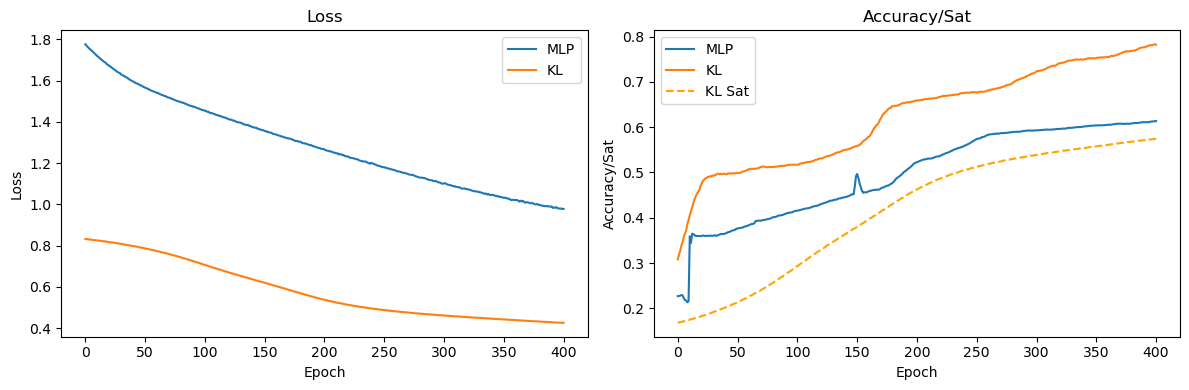

In [4]:
with open("MLP_acc.txt", "r") as f:
    mlp_results = [parse_mlp(line) for line in f if line.strip()]

with open("KL_acc_sat.txt", "r") as f:
    kan_results = [parse_kan(line) for line in f if line.strip()]

mlp_loss, mlp_acc = zip(*mlp_results)
kan_loss, kan_acc, kan_sat = zip(*kan_results)

# Plot the results
# Figure 1: loss for MLP and KL
# Figure 2: accuracy for MLP and KL

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(mlp_loss, label="MLP")
axs[0].plot(kan_loss, label="KL")
axs[0].set_title("Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].plot(mlp_acc, label="MLP")
axs[1].plot(kan_acc, label="KL")
axs[1].plot(kan_sat, label="KL Sat", linestyle="--", color="orange")
axs[1].set_title("Accuracy/Sat")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy/Sat")
axs[1].legend()

plt.tight_layout()
plt.show()


Key observation: The basic perfermance is kept, and outperform
* [Convergence] faster
* [SAT] unique feature for KL
* [Acc] better


2. Hierarchy-KAN

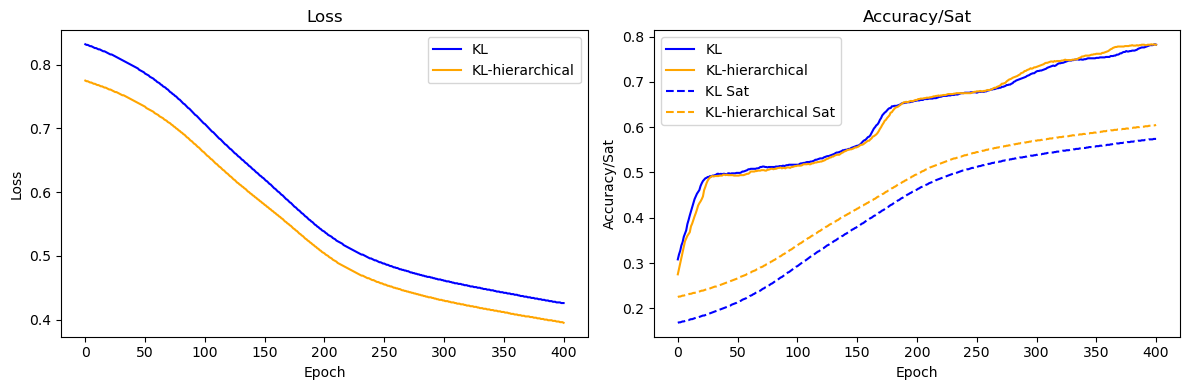

In [5]:
# Plot KL-hierarchical vs KL in one figure
with open("KL_hierarchy.txt", "r") as f:
    kan_hierarchical_results = [parse_kan(line) for line in f if line.strip()]

kan_hierarchical_loss, kan_hierarchical_acc, kan_hierarchical_sat = zip(*kan_hierarchical_results)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(kan_loss, label="KL", color="blue")
axs[0].plot(kan_hierarchical_loss, label="KL-hierarchical", color="orange")
axs[0].set_title("Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].plot(kan_acc, label="KL", color="blue")
axs[1].plot(kan_hierarchical_acc, label="KL-hierarchical", color="orange")
axs[1].plot(kan_sat, label="KL Sat", linestyle="--", color="blue")
axs[1].plot(kan_hierarchical_sat, label="KL-hierarchical Sat", linestyle="--", color="orange")
axs[1].set_title("Accuracy/Sat")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy/Sat")
axs[1].legend()

plt.tight_layout()
plt.show()

Key observation:
* [SAT] hierarchical rules complement the knowledge
* [Loss vs Sat] flip margin between loss and Sat
* [Acc] keep same, but model is more confident

**KL Plot**
* tuning activition num in each layer 

checkpoint directory created: ./model
saving model version 0.0
Epoch 0 | KAN (loss/acc/sat): 0.772/0.181/0.228(0.229)
Epoch 10 | KAN (loss/acc/sat): 0.769/0.279/0.231(0.232)
Epoch 20 | KAN (loss/acc/sat): 0.765/0.293/0.235(0.236)
Epoch 30 | KAN (loss/acc/sat): 0.760/0.296/0.240(0.242)
Epoch 40 | KAN (loss/acc/sat): 0.753/0.295/0.247(0.249)
Epoch 50 | KAN (loss/acc/sat): 0.744/0.297/0.256(0.258)
Epoch 60 | KAN (loss/acc/sat): 0.734/0.435/0.266(0.268)
Epoch 70 | KAN (loss/acc/sat): 0.722/0.422/0.278(0.281)
Epoch 80 | KAN (loss/acc/sat): 0.708/0.428/0.292(0.295)
Epoch 90 | KAN (loss/acc/sat): 0.692/0.460/0.308(0.312)
Epoch 100 | KAN (loss/acc/sat): 0.674/0.498/0.326(0.330)
Epoch 110 | KAN (loss/acc/sat): 0.655/0.500/0.345(0.349)
Epoch 120 | KAN (loss/acc/sat): 0.636/0.506/0.364(0.368)
Epoch 130 | KAN (loss/acc/sat): 0.617/0.513/0.383(0.387)
Epoch 140 | KAN (loss/acc/sat): 0.598/0.531/0.402(0.405)
Epoch 150 | KAN (loss/acc/sat): 0.579/0.560/0.421(0.423)
Epoch 160 | KAN (loss/acc/sat): 0.56

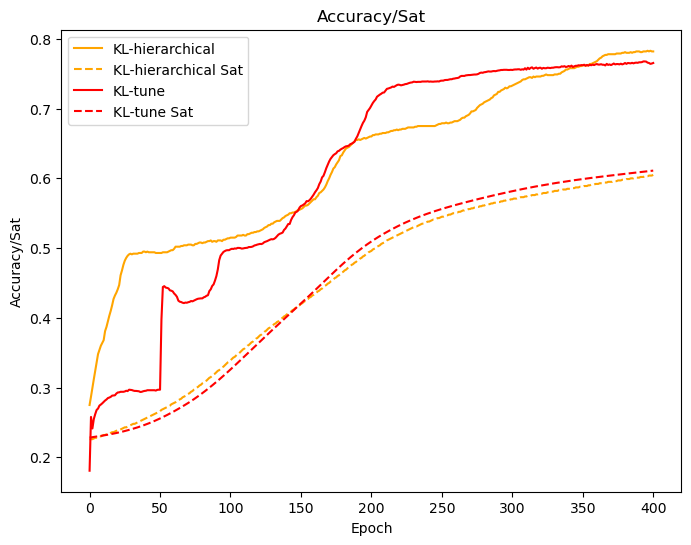

In [6]:
def compute_sat_levels(loader, P):
	sat_level  = 0
	for data, labels in loader:
		x = ltn.Variable("x", data)
		x_MQTT_DDoS_Connect_Flood = ltn.Variable("x_MQTT_DDoS_Connect_Flood", data[labels == 0])
		x_MQTT_DDoS_Publish_Flood = ltn.Variable("x_MQTT_DDoS_Publish_Flood", data[labels == 1])
		x_MQTT_DoS_Connect_Flood = ltn.Variable("x_MQTT_DoS_Connect_Flood", data[labels == 2])
		x_MQTT_DoS_Publish_Flood = ltn.Variable("x_MQTT_DoS_Publish_Flood", data[labels == 3])
		x_MQTT_Malformed_Data = ltn.Variable("x_MQTT_Malformed_Data", data[labels == 4])
		x_Benign = ltn.Variable("x_Benign", data[labels == 5])

		x_MQTT = ltn.Variable("x_MQTT", data[labels < 5])
		
		sat_level = SatAgg(
			Forall(x_MQTT_DDoS_Connect_Flood, P(x_MQTT_DDoS_Connect_Flood, l_MQTT_DDoS_Connect_Flood)),
			Forall(x_MQTT_DDoS_Publish_Flood, P(x_MQTT_DDoS_Publish_Flood, l_MQTT_DDoS_Publish_Flood)),
			Forall(x_MQTT_DoS_Connect_Flood, P(x_MQTT_DoS_Connect_Flood, l_MQTT_DoS_Connect_Flood)),
			Forall(x_MQTT_DoS_Publish_Flood, P(x_MQTT_DoS_Publish_Flood, l_MQTT_DoS_Publish_Flood)),
			Forall(x_MQTT_Malformed_Data, P(x_MQTT_Malformed_Data, l_MQTT_Malformed_Data)),
			Forall(x_Benign, P(x_Benign, l_Benign)),
			# hierarchical constraints
			Forall(x_MQTT, Not(P(x_MQTT, l_Benign)))
		)
	return sat_level
    
kan_h = KAN(width=[18, 6, 6, 6], grid=5, k=3, seed=42, device=device)
P_kan = ltn.Predicate(LogitsToPredicate(MultiKANModel(kan_h)))

optimizer_kan = torch.optim.Adam(P_kan.parameters(), lr=0.001)

sat_tune = []
acc_tune = []
for epoch in range(401):
    # Train the KAN
	optimizer_kan.zero_grad()
	sat_kan = compute_sat_levels(train_loader, P_kan)
	loss = 1. - sat_kan
	loss.backward()
	optimizer_kan.step()
	train_loss_kan = loss.item()

	sat_tune.append(sat_kan.item())

	# Test the KAN
	acc_kan = compute_accuracy(test_loader, kan_h)
	acc_tune.append(acc_kan.item())
	if epoch % 10 == 0:
		test_sat_kan = compute_sat_levels(test_loader, P_kan)
		print(f"Epoch {epoch} | KAN (loss/acc/sat): {train_loss_kan:.3f}/{acc_kan:.3f}/{sat_kan:.3f}({test_sat_kan:.3f})")

# Plot the results
with open("KL_hierarchy.txt", "r") as f:
    kan_hierarchical_results = [parse_kan(line) for line in f if line.strip()]

_, kan_hierarchical_acc, kan_hierarchical_sat = zip(*kan_hierarchical_results)
kan_2_10_acc, kan_2_10_sat = acc_tune, sat_tune

# show acc and sat on same plot
fig, axs = plt.subplots(figsize=(8, 6))
axs.plot(kan_hierarchical_acc, label="KL-hierarchical", color="orange")
axs.plot(kan_hierarchical_sat, label="KL-hierarchical Sat", linestyle="--", color="orange")
axs.plot(kan_2_10_acc, label="KL-tune", color="red")
axs.plot(kan_2_10_sat, label="KL-tune Sat", linestyle="--", color="red")
axs.set_title("Accuracy/Sat")
axs.set_xlabel("Epoch")
axs.set_ylabel("Accuracy/Sat")
axs.legend()
plt.show()